# Counterfactual Analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Set working directory to '/n/groups/patel/shakson/aiready/'
import os
os.chdir("/home/shaksonisaac/CGM/mambatf/")

In [3]:
#LOAD Datasets
import pandas as pd
import io
from google.cloud import storage

_BUCKET_NAME = "cgmproject2025"

# Download dataset from GCS
client = storage.Client()
bucket = client.bucket(_BUCKET_NAME)
blob = bucket.blob('ai-ready/data/train_timeseries_meal.feather')
data_bytes = blob.download_as_bytes()
train = pd.read_feather(io.BytesIO(data_bytes))


# Download test set:
client = storage.Client()
bucket = client.bucket(_BUCKET_NAME)
blob = bucket.blob('ai-ready/data/test_timeseries_meal.feather')
data_bytes = blob.download_as_bytes()
test = pd.read_feather(io.BytesIO(data_bytes))

In [4]:
# Load Data
import os
import sys

#from TFT_pytorch import log_memory, create_tft_dataloaders, TFT_train
from scripts.mamba288 import create_tft_dataloaders, TFT_train, save_tft_to_gcs, load_tft_from_gcs

/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [5]:
# Rebuild the training dataset (same context_length, horizon, etc.)
training, val_dataloader, train_dataloader, validation = create_tft_dataloaders(train, horizon=12, context_length=288, batchsize=32)

[2025-08-07 15:49:32.892403] Start of Dataloader Creation
GPU Mem allocated: 0.00 GB | reserved: 0.00 GB


# Updated the code for Mamba (needs everything on GPU error)

In [6]:
import torch
tft = load_tft_from_gcs(model_name="MambaTFT_12horizon_288context_meal", training_dataset=training)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tft = tft.to(device)   # <— this must move *every* sub‐module (including the Mamba blocks)  
tft.eval()  # Put model in evaluation mode

/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Loaded TFT from gs://cgmproject2025/models/predictions/MambaTFT_12horizon_288context_meal/


MambaTFT(
  	"attention_head_size":               2
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'ds', 'target': 'cgm_glucose', 'group_ids': ['participant_id'], 'weight': None, 'max_encoder_length': 288, 'min_encoder_length': 288, 'min_prediction_idx': np.int64(11), 'min_prediction_length': 12, 'max_prediction_length': 12, 'static_categoricals': ['participant_id', 'clinical_site', 'study_group'], 'static_reals': ['age'], 'time_varying_known_categoricals': ['sleep_stage'], 'time_varying_known_reals': ['ds', 'minute_of_day', 'tod_sin', 'tod_cos', 'activity_steps', 'calories_value', 'heartrate', 'oxygen_saturation', 'respiration_rate', 'stress_level', 'predmeal_flag'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['cgm_glucose', 'cgm_lag_1', 'cgm_lag_3', 'cgm_lag_6', 'cgm_diff_lag_1', 'cgm_diff_lag_3', 'cgm_diff_lag_6', 'cgm_lagdiff_1_3', 'cgm_lagdiff_3_6', 'cgm_roll

### Counterfactual Analysis

Individual   μ = 11.321, σ = 6.289
Population   μ = 10.922, σ = 6.204
raw_p (μₚ+2σₚ) = 23.330 → z_p→i = 1.910


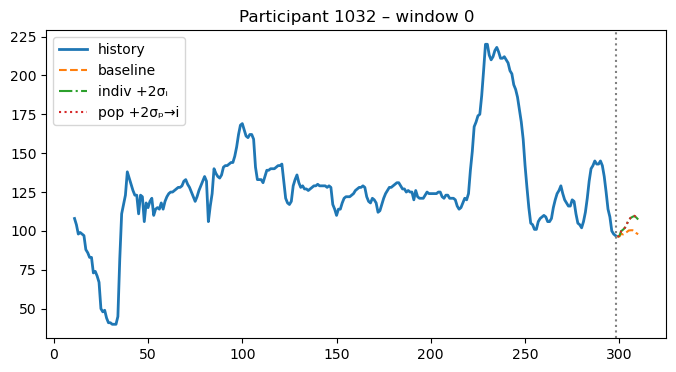

In [7]:
# ------------------------------------------------------------------
# Full notebook cell: baseline vs. individual‐2σ vs. population‐2σ→individual
# ------------------------------------------------------------------
import torch
import matplotlib.pyplot as plt
from pytorch_forecasting import TimeSeriesDataSet

# --- User parameters ---
target_id      = "1032"       # participant to analyze
covariate_name = "respiration_rate"   # covariate to intervene on
k              = 0            # which window index to plot
counterfact_std = 2.0         # Counterfactual: How many standard deviations away do we apply:

# --- 0) Compute individual & population stats on raw data ---
sub      = train[train["participant_id"] == target_id]
mu_i     = sub[covariate_name].mean()
sigma_i  = sub[covariate_name].std()

mu_p     = train[covariate_name].mean()
sigma_p  = train[covariate_name].std()

# raw population value at +2σ_p
raw_p    = mu_p + counterfact_std * sigma_p
# how many σ_i that represents for this individual
z_p_to_i = (raw_p - mu_i) / sigma_i

print(f"Individual   μ = {mu_i:.3f}, σ = {sigma_i:.3f}")
print(f"Population   μ = {mu_p:.3f}, σ = {sigma_p:.3f}")
print(f"raw_p (μₚ+2σₚ) = {raw_p:.3f} → z_p→i = {z_p_to_i:.3f}")

# --- 1) Build full-window dataset & DataLoader ---
full_train_ds = TimeSeriesDataSet.from_dataset(
    training,            # the TimeSeriesDataSet used to train your TFT
    sub,                 # only this participant’s rows
    stop_randomization=True,
    predict=False
)
train_dl = full_train_ds.to_dataloader(train=False, batch_size=1, num_workers=0)
cov_idx  = full_train_ds.reals.index(covariate_name)

# --- 2) Loop: collect baseline + two counterfactuals ---
tft.eval()
xs, base_preds, cf_i_preds, cf_pi_preds = [], [], [], []

device = next(tft.parameters()).device # Move to Correct Device

for x, y in train_dl:
    with torch.no_grad():
        x = {k: v.to(device) for k, v in x.items()} # Move to Correct Device
        # baseline forecast
        base = tft(x)

        # individual +2σᵢ counterfactual
        #raw_i = mu_i + 2.0 * sigma_i
        #z_i   = (raw_i - mu_i) / sigma_i  # == 2.0
        x_i   = {k: v.clone() for k, v in x.items()}
        x_i["decoder_cont"][..., cov_idx] = counterfact_std
        cf_i  = tft(x_i)

        # population +2σₚ → individual-z counterfactual
        x_pi  = {k: v.clone() for k, v in x.items()}
        x_pi["decoder_cont"][..., cov_idx] = z_p_to_i
        cf_pi = tft(x_pi)

    xs.append(x)
    base_preds.append(base)
    cf_i_preds.append(cf_i)
    cf_pi_preds.append(cf_pi)

# --- 3) Plot helper for three forecasts ---
def plot_three_preds(x_dict, base, cf_i, cf_pi, title=None):
    # extract raw [B,H,Q] tensors
    def extract(pred):
        if isinstance(pred, tuple):
            pred = pred[0]
        return pred.detach().cpu()
    pb = extract(base)
    pi = extract(cf_i)
    pp = extract(cf_pi)

    # slice median quantiles
    q50_b = pb[0, :, 1]
    q50_i = pi[0, :, 1]
    q50_p = pp[0, :, 1]
    # (optional: also extract q05/q95 if you want shading)

    # rebuild time axes
    t_dec   = x_dict["decoder_time_idx"][0].cpu()
    enc_len = x_dict["encoder_lengths"][0].item()
    start   = t_dec[0].item() - enc_len
    t_enc   = torch.arange(start, start + enc_len)
    y_enc   = x_dict["encoder_target"][0].cpu()

    # plot
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(t_enc, y_enc,               label="history", lw=2)
    ax.plot(t_dec, q50_b, ls="--",      label="baseline")
    ax.plot(t_dec, q50_i, ls="-.",      label="indiv +2σᵢ")
    ax.plot(t_dec, q50_p, ls=":",       label="pop +2σₚ→i")
    ax.axvline(t_dec[0] - 0.5, color="gray", ls=":")
    ax.legend()
    ax.set_title(title or f"Participant {target_id} – window {k}")
    plt.show()

# --- 4) Plot the k-th window ---
plot_three_preds(
    xs[k],
    base_preds[k],
    cf_i_preds[k],
    cf_pi_preds[k],
    title=f"Participant {target_id} – window {k}"
)

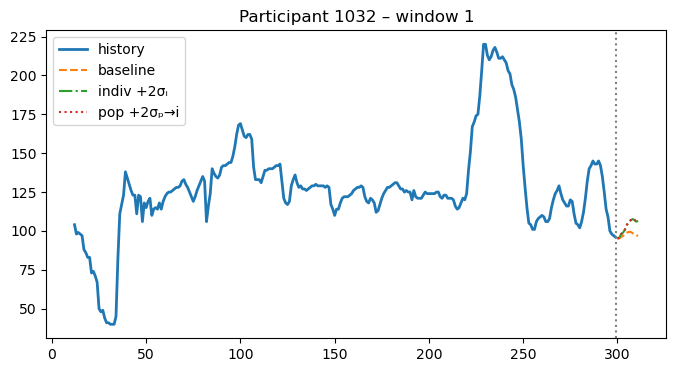

In [9]:
k = 1
plot_three_preds(
    xs[k],
    base_preds[k],
    cf_i_preds[k],
    cf_pi_preds[k],
    title=f"Participant {target_id} – window {k}"
)

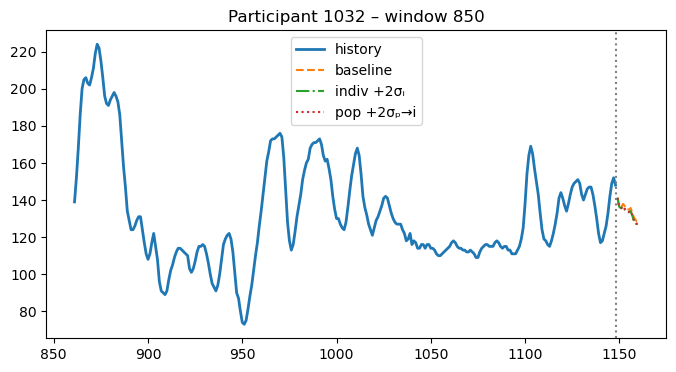

In [35]:
k = 850
plot_three_preds(
    xs[k],
    base_preds[k],
    cf_i_preds[k],
    cf_pi_preds[k],
    title=f"Participant {target_id} – window {k}"
)

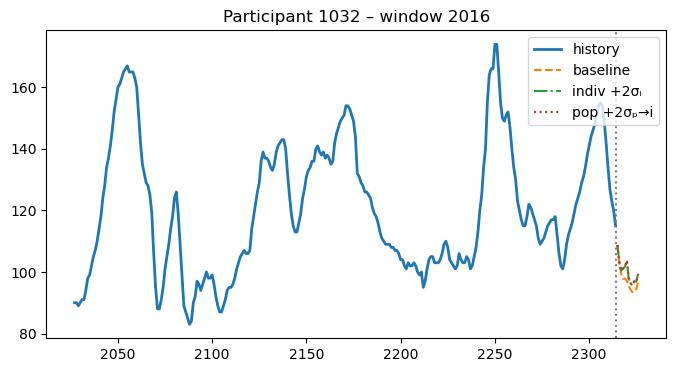

In [8]:
idx_try = 2100
context = 72 + 12
k = idx_try - context
# --- 4) Plot the k-th window ---
plot_three_preds(
    xs[k],
    base_preds[k],
    cf_i_preds[k],
    cf_pi_preds[k],
    title=f"Participant {target_id} – window {k}"
)